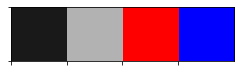

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import matplotlib
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import seaborn as sns
import time

sys.setrecursionlimit(10000)

%matplotlib inline
init_notebook_mode(connected=True)

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None # turn off SettingWithCopyWarning

np.random.seed(1234)
directory = os.path.join("..", "data", "gowalla") 


def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    matplotlib.rc("font", family="Times New Roman")

    
def get_colors():
    return np.array([
        [0.1, 0.1, 0.1],          # black
        # [0.4, 0.4, 0.4],          # very dark gray
        [0.7, 0.7, 0.7],          # dark gray
        # [0.9, 0.9, 0.9],          # light gray
        'red',                     
        'blue'
    ])
        
        
def set_size(fig, w=6, h=3):
    fig.set_size_inches(w, h)
    plt.tight_layout()

    
sns.palplot(get_colors())

# SoCal Data

In [2]:
# events = pd.read_csv(
#     os.path.join(directory, 'loc-gowalla_totalCheckins.txt'), 
#     sep="\t", 
#     header=None,
# )
# events.columns = ['uid', 't', 'lat', 'lon', 'location_id']
# events['t'] = pd.to_datetime(events.t)
# events.head()

In [3]:
# socal = events.loc[(events.lat >= 32.54) & (events.lat <= 34.51) & 
#                    (events.lon >= -119.4) & (events.lon <= -116.15)]
# socal['day_id'] = (socal.t - min(socal.t)).dt.days
# socal.to_csv(os.path.join(directory, 'socal.csv'), index=False)

In [4]:
# EVENT DATA COUNTS
socal = pd.read_csv(os.path.join(directory, 'socal.csv'), parse_dates=['t'])
print("Events:", socal.shape[0])
print("Users:", socal.uid.nunique())
print("Avg:", round(socal.shape[0] / socal.uid.nunique(), 1))

Events: 276924
Users: 8459
Avg: 32.7


In [5]:
# VISIT DATA COUNTS
visits = pd.read_csv(os.path.join(directory, "visits.csv"), parse_dates=['t'])
print("Events:", visits.shape[0])
print("Users:", visits.uid.nunique())
print("Avg:", round(visits.shape[0] / visits.uid.nunique(), 1))

Events: 275956
Users: 8459
Avg: 32.6


In [6]:
visits.head()

,uid,t,lat,lon,location_id,day_id,epoch_time,visit
0,75672,2009-03-18 02:08:09+00:00,34.017588,-118.487055,9518,0,1237342089,0
1,75672,2009-03-18 04:00:59+00:00,34.018135,-118.489630,9523,0,1237348859,1
2,2687,2009-03-18 22:27:29+00:00,32.764272,-117.226653,9540,0,1237415249,0
3,2687,2009-03-20 19:45:58+00:00,33.812065,-117.919006,9724,2,1237578358,1
4,2687,2009-03-21 04:51:18+00:00,34.134361,-118.361485,9780,3,1237611078,2


# Make Visits

In [7]:
d = 0.05  # 50 m
t = 60**2  # number of s in one hr

def spherical_dist(pos1, r=6371):
    """
    return distance matrix in km
    
    https://stackoverflow.com/questions/19413259/efficient-way-to-calculate-distance-matrix-given-latitude-and-longitude-data-in
    """
    pos2 = np.array(pos1)
    pos1 = np.array(pos1)[:, None]
    pos1 = np.deg2rad(pos1)
    pos2 = np.deg2rad(pos2)
    cos_lat1 = np.cos(pos1[..., 0])
    cos_lat2 = np.cos(pos2[..., 0])
    cos_lat_d = np.cos(pos1[..., 0] - pos2[..., 0])
    cos_lon_d = np.cos(pos1[..., 1] - pos2[..., 1])
    return r * np.arccos(cos_lat_d - cos_lat1 * cos_lat2 * (1 - cos_lon_d))

def temporal_dist(times):
    """matrix of time differences"""
    times = np.array(times)
    return np.abs(np.subtract.outer(times, times))

def invert_dict(d): 
    """reverse a dictionary with list/set values"""
    inverse = dict() 
    for key in d: 
        for item in d[key]:
            inverse[item] = key
    return inverse

def set_visits(df):
    """
    :param df: pd.DataFrame for one user with <lat, lon, epoch_time> columns
    :return: same pd.DataFrame with a visit column containing integer visit id
    """
    # find groups of points that meet both the dist and time criteria for a visit
    distance_match = spherical_dist(df[['lat', 'lon']]) <= d
    time_match = temporal_dist(df['epoch_time']) <= t
    matches = distance_match & time_match
    groups = {}
    i = 0
    for row_i, row in enumerate(matches):
        v = list([i for i, is_true in enumerate(row) if is_true])
        if v not in groups.values():
            groups[i] = v
            i += 1
    df['visit'] = invert_dict(groups).values()
    return df


# socal = socal.sort_values('t')
# socal['epoch_time'] = socal['t'].values.astype(np.int64) // 10**9  # in seconds
# visits = socal.groupby('uid').apply(set_visits)
# visits = visits.drop_duplicates(['uid', 'location_id', 'visit'])
# visits.to_csv(os.path.join(directory, "visits.csv"), index=False)

# Distn of visits over time

In [8]:
test = visits.set_index(['t'])
month_cts = test.groupby(pd.Grouper(freq='M'))['uid'].count()
month_cts

t
2009-03-31 00:00:00+00:00        8
2009-04-30 00:00:00+00:00       12
2009-05-31 00:00:00+00:00        3
2009-06-30 00:00:00+00:00        1
2009-07-31 00:00:00+00:00       38
2009-08-31 00:00:00+00:00       20
2009-09-30 00:00:00+00:00      306
2009-10-31 00:00:00+00:00     1701
2009-11-30 00:00:00+00:00     3004
2009-12-31 00:00:00+00:00    10969
2010-01-31 00:00:00+00:00    16468
2010-02-28 00:00:00+00:00    16161
2010-03-31 00:00:00+00:00    23526
2010-04-30 00:00:00+00:00    25668
2010-05-31 00:00:00+00:00    25090
2010-06-30 00:00:00+00:00    24689
2010-07-31 00:00:00+00:00    32757
2010-08-31 00:00:00+00:00    36526
2010-09-30 00:00:00+00:00    33318
2010-10-31 00:00:00+00:00    25691
Freq: M, Name: uid, dtype: int64

# Distn of locations

In [9]:
# location weights based on number of visits
locs = visits.groupby('location_id')['uid'].count()
wt_e = pd.DataFrame(locs).reset_index().rename(columns={'uid': 'weight'})
wt_e['weight'] = 1 / wt_e['weight']

# location weights based on number of unique users at location
locs_users = visits.groupby(['location_id'])['uid'].nunique()
wt_u = pd.DataFrame(locs_users).reset_index().rename(columns={'uid': 'weight'})
wt_u['weight'] = 1 / wt_u['weight']

# merge weights in to the point pattern data
visits = pd.merge(visits, wt_e, on='location_id')
visits = pd.merge(visits, wt_u, on='location_id', suffixes=('_event', '_user'))

visits.head()

,uid,t,lat,lon,location_id,day_id,epoch_time,visit,weight_event,weight_user
0,75672,2009-03-18 02:08:09+00:00,34.017588,-118.487055,9518,0,1237342089,0,0.003953,0.029412
1,4193,2009-12-10 01:24:59+00:00,34.017588,-118.487055,9518,266,1260408299,0,0.003953,0.029412
2,7472,2009-12-10 19:23:40+00:00,34.017588,-118.487055,9518,267,1260473020,0,0.003953,0.029412
3,5433,2009-12-10 19:27:01+00:00,34.017588,-118.487055,9518,267,1260473221,0,0.003953,0.029412
4,71673,2009-12-11 19:31:55+00:00,34.017588,-118.487055,9518,268,1260559915,0,0.003953,0.029412


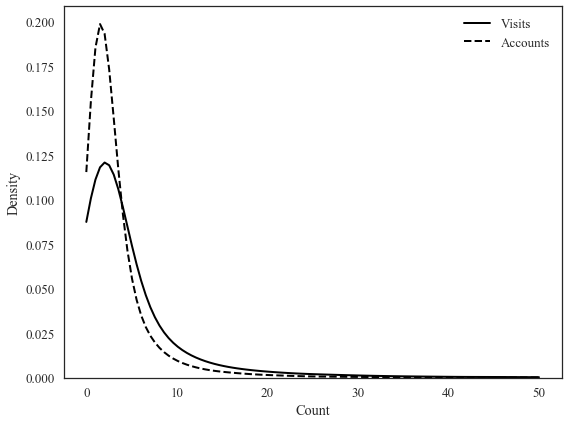

In [10]:
set_style()

f, ax = plt.subplots()

ax = sns.kdeplot(
    locs, 
    color = 'black',
    lw=2,
    clip=(0,50),
    label='Visits'
)
ax = sns.kdeplot(
    locs_users, 
    color = 'black',
    linestyle = 'dashed',
    lw=2,
    clip=(0,50),
    label='Accounts'
)
ax.set(ylabel="Density")
ax.set(xlabel="Count")

set_size(f, 8, 6)

plt.show()

In [11]:
locs.describe()  # visit cts

count    52097.000000
mean         5.296965
std         19.677789
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       3345.000000
Name: uid, dtype: float64

In [12]:
locs_users.describe()  # unique user counts

count    52097.000000
mean         3.549187
std         11.628129
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       1898.000000
Name: uid, dtype: float64

In [13]:
common_locs = locs_users.loc[locs_users >= visits.uid.nunique()*0.5].index  # locations with >50% of users visiting
len(common_locs)

0

# Create MPP

In [14]:
### A == Oct 2010; B == Sept 2010
a_start = '2010-10-01'
a_end = '2010-11-01'    
b_start = '2010-09-01'
b_end = '2010-10-01'

a = visits.loc[(visits.t >= a_start) & (visits.t <= a_end)]
b = visits.loc[(visits.t >= b_start) & (visits.t <= b_end)]

In [15]:
common_users = np.intersect1d(a.uid.unique(), b.uid.unique())
a = a.loc[a.uid.isin(common_users)]
b = b.loc[b.uid.isin(common_users)]

In [16]:
### A
print("Obs days:", a.day_id.nunique())
print("Visits:", len(a))
print("Users:", a.uid.nunique())
print("Avg:", round(len(a)/a.uid.nunique(), 1))

Obs days: 24
Visits: 16682
Users: 1214
Avg: 13.7


In [17]:
### B
print("Obs days:", b.day_id.nunique())
print("Visits:", len(b))
print("Users:", b.uid.nunique())
print("Avg:", round(len(b)/b.uid.nunique(), 1))

Obs days: 31
Visits: 26448
Users: 1214
Avg: 21.8


In [18]:
### create mpp data frame
keep_cols = ["uid", "lat", "lon", "m", 'location_id']
a['m'] = 'a'
b['m'] = 'b'
mpp = pd.concat([a[keep_cols], b[keep_cols]]).reset_index(drop=True)
mpp.head()

,uid,lat,lon,m,location_id
0,1498,34.017588,-118.487055,a,9518
1,1498,34.017588,-118.487055,a,9518
2,2311,34.017588,-118.487055,a,9518
3,1498,34.017588,-118.487055,a,9518
4,1498,34.017588,-118.487055,a,9518


In [19]:
# merge weights in to the point pattern data
mpp = pd.merge(mpp, wt_e, on='location_id')
mpp = pd.merge(mpp, wt_u, on='location_id', suffixes=('_event', '_user'))
# mpp.to_csv(os.path.join(directory, "mpp_octA_septB.csv"), index=False)

mpp = pd.read_csv(os.path.join(directory, "mpp_octA_septB.csv"))
mpp.head()

,uid,lat,lon,m,location_id,weight_event,weight_user
0,1498,34.017588,-118.487055,a,9518,0.003953,0.029412
1,1498,34.017588,-118.487055,a,9518,0.003953,0.029412
2,2311,34.017588,-118.487055,a,9518,0.003953,0.029412
3,1498,34.017588,-118.487055,a,9518,0.003953,0.029412
4,1498,34.017588,-118.487055,a,9518,0.003953,0.029412


# Plot some examples

In [20]:
import branca.colormap as cm
from branca.element import Template, MacroElement
from collections import defaultdict
import folium
from folium.plugins import HeatMap, MarkerCluster

### https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:24px; left: 20px; bottom: 40px;'>
     
<div class='legend-title'></div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:black;'></span>A</li>
    <li><span style='background:red;'></span>B</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 10px;
    width: 10px;
    -webkit-border-radius: 5px;
    -moz-border-radius: 5px;
    border-radius: 5px;
    margin-right: 5px;
    margin-left: 0;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""


def calc_freqs(df):
    ### grid the population data for OC & count visits in each bin
    data = df.copy()
    data["lat_r"] = data.lat.round(3)
    data["lon_r"] = data.lon.round(3)
    freqs = (
        data.groupby(["lat_r", "lon_r"]).count().reset_index()[["lat_r", "lon_r", "key"]]
    )
    freqs.columns = ["lat_r", "lon_r", "freq"]
    return freqs


def get_user(mpp, uid, mark):
    out = mpp.copy()
    # out = out.drop_duplicates(subset=["location_id", "m"])
    return out.loc[(out.uid == uid) & (out.m == mark)].reset_index(drop=True)


def make_user_scatter_plot(mpp, uid, mark):
    user = get_user(mpp, uid, mark)
    return list(zip(user.lat, user.lon))


def plot_heat_and_scatter(mpp, uid, freqs=None, uidB=None, heat=False):
    if uidB is None:
        uidB = uid
    if heat:
        col = 'lightgreen'
        opacity = 0.8
    else:
        col = 'red'
        opacity = 0.75
    
    ### make the map
    hmap = folium.Map(
        location=[33.525, -117.775],
        width='100%', 
        zoom_start=8,
        zoom_control=False,
        tiles='CartoDB positron',
    )
    
    ### make the heatmap
    if heat:
        steps = 20
        color_map = cm.linear.YlOrRd_09.scale(0, 1).to_step(steps)

        gradient_map = defaultdict(dict)
        for i in range(steps):
            gradient_map[1/steps*i] = color_map.rgb_hex_str(1/steps*i)

        heat = HeatMap( 
            data=list(zip(freqs['lat_r'], freqs['lon_r'], freqs['freq'])),
            min_opacity=0.2,
            max_val=float(freqs['freq'].max()),
            radius=25, 
            blur=16, 
            max_zoom=5, 
            gradient=gradient_map
        )
        
        hmap.add_child(heat)
        hmap.add_child(color_map)

    ### make the scatters
    f = folium.map.FeatureGroup()
    for pt in make_user_scatter_plot(mpp, uid, 'a'):
        f.add_child(
            folium.vector_layers.CircleMarker(
                pt,
                radius=4,
                color=None,
                fill_color='black',
                fill_opacity=0.75)
        )

    for pt in make_user_scatter_plot(mpp, uidB, 'b'):
        f.add_child(
            folium.vector_layers.CircleMarker(
                pt,
                radius=4,
                color=None,
                fill_color=col,
                fill_opacity=opacity)
        )
    hmap.add_child(f)

    ### add legend
    macro = MacroElement()
    macro._template = Template(template)
    hmap.get_root().add_child(macro)

    return hmap


def map_to_png(m, filename):
    fn='figs/tempmap.html'
    tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
    m.save(fn)

    driver = webdriver.Chrome()
    # driver.set_window_size(400, 300)  # choose a resolution
    driver.get(tmpurl)

    time.sleep(5)  # give the map tiles some time to load
    driver.save_screenshot(filename)
    driver.quit()
    

In [21]:
from IPython import display
from random import sample

users = mpp.uid.unique()
for u in sample(list(users), 10):
    m = plot_heat_and_scatter(
        mpp=mpp, 
        uid=u, 
    )
    display.clear_output(wait=True)
    display.display(m)
    time.sleep(1.5)

# Population KDE

In [22]:
### conversion factors
# latitude = 40.74

# e = 0.00669437999014
# a = 6378.137
# lat_to_km = round(1 / ((np.pi*a*(1-e))/ (180*(1-e*(np.sin(latitude))**2)**(3/2))), 6)
# lon_to_km =  round(1 / (np.cos(latitude*np.pi/180)*111.321), 6)

lon_to_km = 0.010615
lat_to_km = 0.008989
print('latitude:', 1 / lat_to_km)
print('longitude:', 1 / lon_to_km)

latitude: 111.24707976415618
longitude: 94.20631182289213


In [24]:
from kde.location_project.kde_2d import (
    KDE,
    MixtureKDE,
    create_individual_component_data,
    learn_nearest_neighbors_bandwidth
)

# learn the bandwidth for each point & save to file (it's expensive)
filepath = os.path.join(directory, "population_visits_kde_data.npy")

# points = visits.loc[:, ['lon', 'lat']].values
# bw_pop = learn_nearest_neighbors_bandwidth(points, lon_to_km=lon_to_km, lat_to_km=lat_to_km, k=5, min_bw=0.05)
# kde_data = np.hstack([points, np.atleast_2d(bw_pop).T])  # adaptive bandwidth
# kde_data = np.append(kde_data, np.ones((len(kde_data), 1)), 1)  # equal weights by default
# np.save(filepath, kde_data)

pop_kde_data = np.load(filepath)
pop_kde_data.shape

(275956, 4)

In [25]:
# create the population KDE
pop_kde = KDE(pop_kde_data)

# # create the individual KDE
# ind_A = (oc_mpp.uid == uA) & (oc_mpp.m == 'a')
# indiv_kde_data = create_individual_component_data(oc_mpp.loc[ind_A, ])
# indiv_kde = KDE(indiv_kde_data)

# # create the mixture KDE
# mix_kde = MixtureKDE(indiv_kde_data, pop_kde_data)


def eval_density(kde, xlim=[-118.2, -117.5], ylim=[33.4, 34], delta = 0.01):  # oc defaults
    x = np.arange(xlim[0], xlim[1], delta)  # longitude
    y = np.arange(ylim[0], ylim[1], delta)  # latitude
    X, Y = np.meshgrid(x, y)
    pts = np.vstack([X.ravel(), Y.ravel()]).T
    z = np.apply_along_axis(kde.log_pdf, 1, pts)
    Z = np.reshape(z, X.shape)
    return X, Y, Z


xlim = [-119.4, -116.15]
ylim = [32.54, 34.51] 
delta = 0.01

# X_i, Y_i, Z_i = eval_density(indiv_kde, xlim=xlim, ylim=ylim, delta=delta)
# X_p, Y_p, Z_p = eval_density(pop_kde, xlim=xlim, ylim=ylim, delta=delta)
# X_m, Y_m, Z_m = eval_density(mix_kde, xlim=xlim, ylim=ylim, delta=delta)

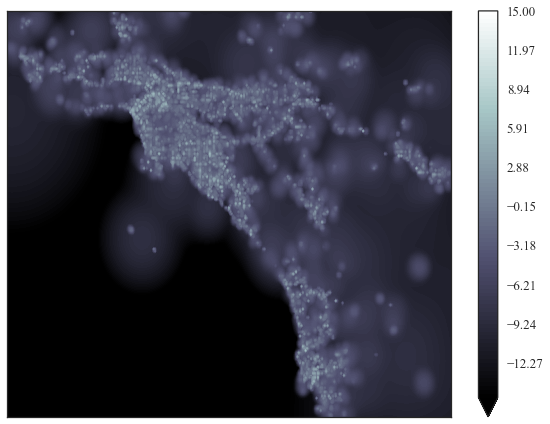

In [26]:
# set_style()

# f, ax = plt.subplots()

# plt.contourf(
#     X_p, Y_p, Z_p, 
#     levels=np.linspace(-15,15,100),
#     cmap='bone',
#     extend='min',
# )
# plt.colorbar()

# plt.xticks([])
# plt.xlabel('')
# plt.yticks([])
# plt.ylabel('')

# set_size(f, 8, 6)

# plt.show()

In [27]:
# Z = (Z_p - np.min(Z_p)) / (np.max(Z_p) - np.min(Z_p))
# out = pd.DataFrame(np.stack([X_p.ravel(), Y_p.ravel(), np.exp(Z_p.ravel()), Z.ravel()], axis=1))
# out = out.rename(columns={0:'lon', 1:'lat', 2:'pdf', 3:'scaled_pdf'})
# out.to_csv(os.path.join(directory, 'population_kde_grid.csv'), index=False)
# out.head()

,lon,lat,pdf,scaled_pdf
0,-119.40,32.54,8.336457e-19,0.046401
1,-119.39,32.54,8.390826e-19,0.046529
2,-119.38,32.54,8.428016e-19,0.046617
3,-119.37,32.54,8.447796e-19,0.046663
4,-119.36,32.54,8.450044e-19,0.046669


# Stratified Sample

In [28]:
### first, look at distn of n_a 
mpp.loc[mpp.m == 'a'].groupby('uid').location_id.count().describe()

count    1214.000000
mean       13.741351
std        21.970354
min         1.000000
25%         2.000000
50%         7.000000
75%        16.000000
max       254.000000
Name: location_id, dtype: float64

In [29]:
### and and n_b
mpp.loc[mpp.m == 'b'].groupby('uid').location_id.count().describe()

count    1214.000000
mean       21.785832
std        42.693392
min         1.000000
25%         4.000000
50%        11.000000
75%        25.000000
max       799.000000
Name: location_id, dtype: float64

In [30]:
### and together
mpp.groupby(['uid', 'm']).location_id.count()

uid     m
2       a     30
        b    686
18      a      9
        b     11
43      a      1
            ... 
195452  b      9
195453  a      7
        b     18
195817  a     16
        b     24
Name: location_id, Length: 2428, dtype: int64

In [32]:
import itertools 
np.random.seed(1234)
splits = [1, 5, 15, float("inf")]

# create all pairwise combinations
ids = mpp.uid.unique()
samp_space = pd.DataFrame(itertools.product(ids, ids), columns=["a", "b"])

# merge in counts of events in A
cts = mpp.groupby(['uid', 'm']).count().reset_index()
cts = cts.loc[cts.m == 'a', ]
cts = cts.rename(columns={"location_id": "n_a"})
cts.n_a.describe()
samp_space = pd.merge(samp_space, cts[['uid', 'n_a']], left_on='a', right_on='uid').drop(columns="uid")

# merge in counts of events in B
cts = mpp.groupby(['uid', 'm']).count().reset_index()
cts = cts.loc[cts.m == 'b', ]
cts = cts.rename(columns={"location_id": "n_b"})
cts.n_b.describe()
samp_space = pd.merge(samp_space, cts[['uid', 'n_b']], left_on='b', right_on='uid').drop(columns="uid")

# bin the number of events in A and B for stratified sampling
samp_space['bin_a'] = pd.cut(samp_space.n_a, bins=splits, right=False)
samp_space['bin_b'] = pd.cut(samp_space.n_b, bins=splits, right=False)

# sample 1000 pairs per combination of bins
sample = samp_space.loc[samp_space.a != samp_space.b,].groupby(['bin_a', 'bin_b']).apply(lambda x: x.sample(1000))
sample.index = sample.index.droplevel(0)
sample.index = sample.index.droplevel(0)

# add in same-source pairs
sample = pd.concat([samp_space.loc[samp_space.a == samp_space.b,], sample], sort=True).reset_index(drop=True)

# sample properties
sample.groupby(['bin_a', 'bin_b'])['a'].count()


bin_a        bin_b      
[1.0, 5.0)   [1.0, 5.0)     1240
             [5.0, 15.0)    1192
             [15.0, inf)    1062
[5.0, 15.0)  [1.0, 5.0)     1054
             [5.0, 15.0)    1152
             [15.0, inf)    1172
[15.0, inf)  [1.0, 5.0)     1024
             [5.0, 15.0)    1040
             [15.0, inf)    1278
Name: a, dtype: int64

# Compute Scores

In [33]:
import itertools
from emd import emd
from kde.location_project.cmp import geodesic_dist


def get_user(mpp, uid, mark):
    out = mpp.copy()
    # out = out.drop_duplicates(subset=["location_id", "m"])
    return out.loc[(out.uid == uid) & (out.m == mark)].reset_index(drop=True)


def population_scores(mpp, keeps):
    rslt = []    
    for index, row in keeps.iterrows():
        user_A = row["a"]
        user_B = row["b"]
        tmp = {}
        try:
            ### get the data for the pair in question
            tmp['a'] = user_A
            tmp['b'] = user_B
            uA = get_user(mpp, user_A, 'a')
            uB = get_user(mpp, user_B, 'b')

            ### compute weights
            uA_wt_e = (uA['weight_event'] / sum(uA['weight_event'])).to_numpy()
            uA_wt_u = (uA['weight_user'] / sum(uA['weight_user'])).to_numpy()
            uB_wt_e = (uB['weight_event'] / sum(uB['weight_event'])).to_numpy()
            uB_wt_u = (uB['weight_user'] / sum(uB['weight_user'])).to_numpy()

            ### compute the distance matrix & IED scores
            dist = geodesic_dist(uA[['lat', 'lon']], uB[['lat', 'lon']])
            ied = dist.min(1)
            tmp['ied_med'] = np.median(ied)
            tmp['ied_mn'] = np.average(ied)
            tmp['ied_mn_wt_event'] = np.average(ied, weights=uA_wt_e)
            tmp['ied_mn_wt_user'] = np.average(ied, weights=uA_wt_u)

            ### compute variants of EMD
            tmp['emd'] = emd(distance="precomputed", D=dist)
            tmp['emd_wt_event'] = emd(
                X_weights=uA_wt_e, Y_weights=uB_wt_e, distance="precomputed", D=dist
            )
            tmp['emd_wt_user'] = emd(
                X_weights=uA_wt_u, Y_weights=uB_wt_u, distance="precomputed", D=dist
            )

            ### store it
            rslt.append(tmp)
        except:
            print(f"Error! A = {user_A}, B = {user_B}")
            continue
    return pd.DataFrame(rslt)


# compute score vals for all pairwise combinations
# score_vals = population_scores(mpp, sample)
# score_vals.to_csv(os.path.join(directory, "score_func_vals.csv"), index=False)
score_vals.head()

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user
0,1498,1498,0.000000,0.538405,0.661559,0.381618,2.455216,3.055116,2.363810
1,2311,2311,0.354563,2.730379,6.122780,6.277989,10.350717,21.072516,18.584963
2,74482,74482,0.522938,2.994007,4.881213,4.565397,6.074390,6.359311,6.917935
3,23331,23331,0.036916,0.036916,0.070879,0.070438,0.394280,0.267480,0.577467
4,2389,2389,0.335532,2.378552,9.357037,8.370727,5.200296,12.943828,11.400364


# Analyze Results

In [97]:
from sklearn.metrics import roc_auc_score

def perf_measure(y_actual, y_hat):
    y_actual = list(y_actual)
    y_hat = list(y_hat)

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)
    
    return (format(round(tpr, 3), '.3f'), format(round(fpr, 3), '.3f'))


def calc_auc(rslt, score, column='label'):
    return format(round(roc_auc_score(rslt[column], rslt[score]), 3), '.3f')


def slr_classifier_performance_for_tex(rslt):
    print("& $\Delta$ & Weights &  TP@1  & FP@1  & AUC \\\\")
    print("\\hline")
    print(
        "& $\mean{D}_{min}$ & Uniform & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['ied_mn'] > 1)), "&", 
        calc_auc(rslt,'ied_mn'), "\\\\"
    ) 
    print(
        "& $\mean{D}_{min}$ & Account  & ",
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['ied_mn_wt_user'] > 1)), "&", 
        calc_auc(rslt,'ied_mn_wt_user'), "\\\\"
    )
    print(
        "& $\mean{D}_{min}$ & Visit    & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['ied_mn_wt_event'] > 1)), "&", 
        calc_auc(rslt,'ied_mn_wt_event'), "\\\\"
    )
    print(
        "& EMD & Uniform & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['emd'] > 1)), "&", 
        calc_auc(rslt,'emd'), "\\\\"
    )
    print(
        "& EMD  & Account & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['emd_wt_user'] > 1)), "&", 
        calc_auc(rslt,'emd_wt_user'), "\\\\"
    )
    print(
        "& EMD  & Visit  & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['emd_wt_event'] > 1)), "&", 
        calc_auc(rslt,'emd_wt_event'), "\\\\"
    )

    

def cmp_classifier_performance_for_tex(rslt):
    print("& $\Delta$ & Weights & TP@0.05  & TP@0.01 & AUC    ")
    print("\\hline")
    print(
        "& $\mean{D}_{min}$ & Uniform  & ", 
        perf_measure(~rslt['label'], rslt['ied_mn'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['ied_mn'] < 0.01)[0], "  &",
        calc_auc(rslt,'ied_mn'), "\\\\"
    ) 
    print(
        "& $\mean{D}_{min}$ & Account & ",
        perf_measure(~rslt['label'], rslt['ied_mn_wt_user'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['ied_mn_wt_user'] < 0.01)[0], "  &",
        calc_auc(rslt,'ied_mn_wt_user'), "\\\\"
    )
    print(
        "& $\mean{D}_{min}$ & Visit & ", 
        perf_measure(~rslt['label'], rslt['ied_mn_wt_event'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['ied_mn_wt_event'] < 0.01)[0], "  &",
        calc_auc(rslt,'ied_mn_wt_event'), "\\\\"
    )
    print(
        "& EMD & Uniform & ", 
        perf_measure(~rslt['label'], rslt['emd'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['emd'] < 0.01)[0], "  &",
        calc_auc(rslt,'emd'), "\\\\"
    )
    print(
        "& EMD & Account & ",
        perf_measure(~rslt['label'], rslt['emd_wt_user'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['emd_wt_user'] < 0.01)[0], "  &",
        calc_auc(rslt,'emd_wt_user'), "\\\\"
    )
    print(
        "& EMD & Visit & ", 
        perf_measure(~rslt['label'], rslt['emd_wt_event'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['emd_wt_event'] < 0.01)[0], "  &",
        calc_auc(rslt,'emd_wt_event'), "\\\\"
    )

In [108]:
slr = pd.read_csv(os.path.join(directory, "slr.csv"))
cmp = pd.read_csv(os.path.join(directory, "cmp.csv"))
lr = pd.read_csv(os.path.join(directory, "lr.csv"))

slr["same-src"] = (slr.a == slr.b).astype(bool)
cmp["same-src"] = (cmp.a == cmp.b).astype(bool)
lr["same-src"] = (lr.a == lr.b).astype(bool)

In [110]:
print("FIXED ALPHA")
print("TP/FP@1", perf_measure(lr['same-src'], lr['lr_alpha_80'] >= 0))
print("AUC", calc_auc(lr, 'lr_alpha_80', 'same-src'))

FIXED ALPHA
TP/FP@1 ('0.000', '0.000')
AUC 0.502


In [111]:
print("STEP ALPHA")
print("TP/FP@1", perf_measure(lr['same-src'], lr['lr_alpha_step'] >= 0))
print("AUC", calc_auc(lr, 'lr_alpha_step', 'same-src'))

STEP ALPHA
TP/FP@1 ('0.000', '0.000')
AUC 0.485


In [112]:
print("FUNC ALPHA")
print("TP/FP@1", perf_measure(lr['same-src'], lr['lr_alpha_func'] >= 0))
print("AUC", calc_auc(lr, 'lr_alpha_func', 'same-src'))

FUNC ALPHA
TP/FP@1 ('0.000', '0.000')
AUC 0.485


In [116]:
slr['label'] = (slr.a == slr.b).astype(bool)
slr_classifier_performance_for_tex(slr)

& $\Delta$ & Weights &  TP@1  & FP@1  & AUC \\
\hline
& $\mean{D}_{min}$ & Uniform &  0.241 & 0.224 & 0.467 \\
& $\mean{D}_{min}$ & Account  &  0.167 & 0.245 & 0.455 \\
& $\mean{D}_{min}$ & Visit    &  0.185 & 0.233 & 0.454 \\
& EMD & Uniform &  0.222 & 0.225 & 0.463 \\
& EMD  & Account &  0.130 & 0.240 & 0.458 \\
& EMD  & Visit  &  0.222 & 0.284 & 0.473 \\


In [117]:
cmp['label'] = (cmp.a != cmp.b).astype(bool)
cmp_classifier_performance_for_tex(cmp)

& $\Delta$ & Weights & TP@0.05  & TP@0.01 & AUC    
\hline
& $\mean{D}_{min}$ & Uniform  &  0.000   & 0.000   & 0.494 \\
& $\mean{D}_{min}$ & Account &  0.000   & 0.000   & 0.508 \\
& $\mean{D}_{min}$ & Visit &  0.000   & 0.000   & 0.512 \\
& EMD & Uniform &  0.037   & 0.000   & 0.506 \\
& EMD & Account &  0.019   & 0.019   & 0.515 \\
& EMD & Visit &  0.019   & 0.000   & 0.520 \\
